# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

In [3]:
alldata = [data_0, data_1, data_2]

Посмотрим на общую информацию о датафреймах:

In [4]:
for data in alldata:
    display(data.head(3))
    display(data.info())
    display()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

В нашем распоряжении 3 датафрейма, состоящие из 4 столбцов и 100000 строк каждый. Первый столбец содержит id - уникальный идентификатор скважины. Эти данные не выжны для построения модели, поэтому сразу удалим этот столбец.

In [5]:
for data in alldata:
    data.drop(columns=['id'],axis=1, inplace=True)

Посмотрим на дубликаты:

In [6]:
for data in alldata:
    display(data.duplicated().sum())

0

0

0

Проверим, есть ли пропущенные значения:

In [7]:
for data in alldata:
    display(data.isnull().sum())

f0         0
f1         0
f2         0
product    0
dtype: int64

f0         0
f1         0
f2         0
product    0
dtype: int64

f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
for data in alldata:
    display(data.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Посмотрим на корреляции в данных: 

In [9]:
for data in alldata:
    display(data.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


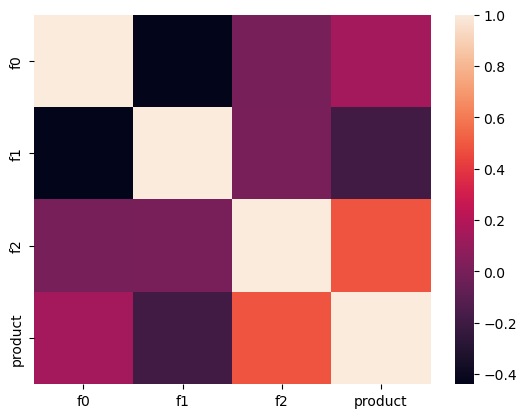

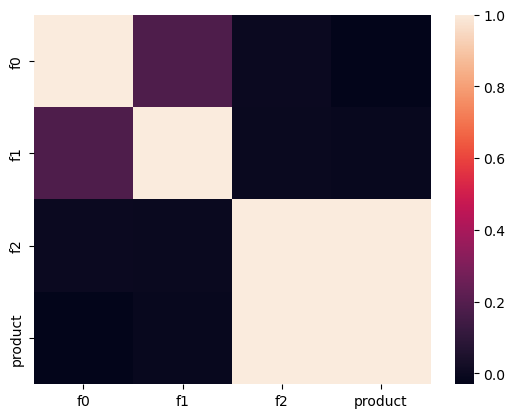

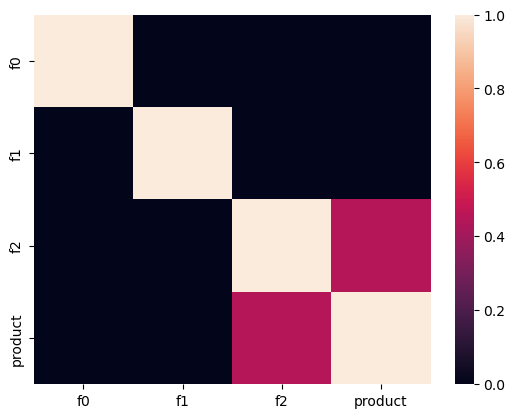

In [10]:
for data in alldata:
    sn.heatmap(data.corr())
    plt.show()

 Действительно(!!!), во втором регионе между f2 и product мы видим корреляцию 0.99. Теоретически, с этим нужно разбираться.

## Обучение и проверка модели

Разобьем данные на обучающую и валидационные выборки в соотношении 75:25. Напишем функцию.

In [11]:
def data_split(data):
    features = data.drop(['product'],axis=1)  
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [12]:
features_train0, features_valid0, target_train0, target_valid0 = data_split(data_0)
features_train1, features_valid1, target_train1, target_valid1 = data_split(data_1)
features_train2, features_valid2, target_train2, target_valid2 = data_split(data_2)

In [13]:
print(features_train0.shape, features_valid0.shape, target_train0.shape, target_valid0.shape)
print(features_train1.shape, features_valid1.shape, target_train1.shape, target_valid1.shape)
print(features_train2.shape, features_valid2.shape, target_train2.shape, target_valid2.shape)

(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)


Обучим модели и сделаем предсказания на валидационной выборке. Напишем функцию.

In [14]:
def linreg_model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
    mean =  predictions_valid.mean()
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    return mean, rmse, predictions_valid

*Первый регион*

In [15]:
mean0, rmse0, predictions_valid0 = linreg_model(features_train0, target_train0, features_valid0, target_valid0)
print('Средний запас предсказанного сырья:', mean0)
print('RMSE модели:', rmse0)

Средний запас предсказанного сырья: 92.59256778438035
RMSE модели: 37.5794217150813


*Второй регион*

In [16]:
mean1, rmse1, predictions_valid1 = linreg_model(features_train1, target_train1, features_valid1, target_valid1)
print('Средний запас предсказанного сырья:', mean1)
print('RMSE модели:', rmse1)

Средний запас предсказанного сырья: 68.728546895446
RMSE модели: 0.8930992867756182


*Третий регион*

In [17]:
mean2, rmse2, predictions_valid2 = linreg_model(features_train2, target_train2, features_valid2, target_valid2)
print('Средний запас предсказанного сырья:', mean2)
print('RMSE модели:', rmse2)

Средний запас предсказанного сырья: 94.96504596800489
RMSE модели: 40.02970873393434


После обучения моделей самый высокий средний запас предсказанного сырья оказался в **третьем регионе** - почти 95 тыс баррелей. RMSE этой модели (корень из средней квадратичной ошибки) равен 40 тыс. баррелей.

## Подготовка к расчёту прибыли

In [18]:
budget_total = 10000000000
income_per_1000bbl = 450000

Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины. Всего выбирают 200 лучших скважин для разработки.

In [19]:
sufficient_volume = budget_total / 200 / income_per_1000bbl
print(sufficient_volume)

111.11111111111111


Минимальный объем сырья, который необходимо добывать для безубыточного функционирования скважины - 111 тыс. баррелей. 

Таким образом получается, что выше предсказанные значения средних запасов сырья во всех трех регионах (первый регион 93 тыс. баррелей, второй регион 69 тыс. баррелей, третий регион 95 тыс. баррелей) меньше необходимого объема для безубыточной разработки новых скважин. 

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели:

In [20]:
def profit(target_valid, predictions_valid):
    predictions_valid_sorted = predictions_valid.sort_values(ascending=False)
    target_volume_sum = target_valid[predictions_valid_sorted.index][:200].sum()
    revenue = target_volume_sum * income_per_1000bbl
    return revenue - budget_total   

Применим технику Bootstrap c 1000 выборок, чтобы найти распределение прибыли:

In [21]:
state = np.random.RandomState(12345)
def bootstrap(target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, predictions_subsample))
    prof = pd.Series(values)
    mean = prof.mean()
    lower = prof.quantile(0.025)
    upper = prof.quantile(0.975)
    risk = stats.percentileofscore(prof, 0)
    return mean, lower, upper, risk

*Первый регион*

In [22]:
mean0, lower0, upper0, risk0 = bootstrap(target_valid0.reset_index(drop=True),pd.Series(predictions_valid0))
print('Средняя прибыль в первом регионе:', round(mean0/1000000), 'млн руб.')
print('95%-й доверительный интервал:', (lower0, upper0))
print('Риск убытков:', risk0, '%')

Средняя прибыль в первом регионе: 426 млн руб.
95%-й доверительный интервал: (-102090094.83793654, 947976353.3583689)
Риск убытков: 6.0 %


*Второй регион*

In [23]:
mean1, lower1, upper1, risk1 = bootstrap(target_valid1.reset_index(drop=True),pd.Series(predictions_valid1))
print('Средняя прибыль во втором регионе:', round(mean1/1000000), 'млн руб.')
print('95%-й доверительный интервал:', (lower1, upper1))
print('Риск убытков:', risk1, '%')

Средняя прибыль во втором регионе: 518 млн руб.
95%-й доверительный интервал: (128123231.43308444, 953612982.0669085)
Риск убытков: 0.30000000000000004 %


*Третий регион*

In [24]:
mean2, lower2, upper2, risk2 = bootstrap(target_valid2.reset_index(drop=True),pd.Series(predictions_valid2))
print('Средняя прибыль в третьем регионе:', round(mean2/1000000), 'млн руб.')
print('95%-й доверительный интервал:', (lower2, upper2))
print('Риск убытков:', risk2, '%')

Средняя прибыль в третьем регионе: 420 млн руб.
95%-й доверительный интервал: (-115852609.16001143, 989629939.8445739)
Риск убытков: 6.2 %


**Основной вывод:**

Наиболее перспективным регионом для добычи нефти получился второй регион, так как там наибольшая средняя прибыль (514 млн. рублей) и наименьший риск убытков.